# Red Generativas Adversas

En el siguiente notebook entrenaremos una GAN sobre MNIST, la cual podrá generar nuevas imágenes de dígitos escritos a mano. 

<img src="images/gan_diagram.png"/>

Esta es la estructura básica de una GAN, donde el generador parte de una imagen que es básicamente ruido, y con e tiempo trata de producir representaciones más realistas de la data. El trabajo del discriminador es, por tanto, discernir cuáles imágenes de las que recibe son reales y cuáles falsas.

Esto proceso adverso termina creando generadores altamente confiables, como veremos al final de este notebook.

## Preliminares

Como de costumbre, importemos las librerías y las dependencias que esta tarea requiere.

In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Data

Como ya mencionamos un par de celdas más arriba, usaremos MNIST. Afortunadamente, TensorFlow facilita la tarea de obtener dicha base de datos al proveer funciones auxiliares muy útiles.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Creando las Entradas del Modelo

Como observamos en el diagrama anterior, una GAN tiene dos entradas: La imagen real y la producida por el generador. Implementemos una función que cree estas entradas:

In [3]:
def model_inputs(real_input_dimensions, generated_input_dimensions):
    real_input = tf.placeholder(tf.float32, (None, real_input_dimensions), name='real_input')
    generated_input = tf.placeholder(tf.float32, (None, generated_input_dimensions), name='generated_input')
    
    return real_input, generated_input

## La Arquitectura

Esta es la arquitectura de nuestro modelo generador:


<img src="images/gan_network.png">

Fíjate que usamos **Leaky ReLUs** en vez de la versión normal. Recuerda que `ReLU(x) = max(0, x)` mientras que `Leaky ReLU(x) = max(c, x)`, donde `c` es una constante cercana a 0. Esto permite que la red siempre envíe una señal, aunque sea pequeña, a las primeras capas durante _backpropagation_ cuando la entrada es negativa, en vez de matarla totalmente como sucede con las ReLUs normales. 

## Generador

Implementemos el generador de la red:

In [4]:
def generator(noisy_input, output_dimensions, number_of_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        hidden_layer = tf.layers.dense(noisy_input, number_of_units, activation=None)
        hidden_layer = tf.maximum(alpha * hidden_layer, hidden_layer)  # Leaky ReLU
        
        # Logits and activation
        logits = tf.layers.dense(hidden_layer, output_dimensions, activation=None)
        out = tf.tanh(logits)
        
        return out

Éstos son los puntos a tener en cuenta:

  - Usamos un _variable scope_ con un nombre en particular porque se lo añadirá como prefijo a todas las variables creadas en dicho scope.
  - El _ariable scope_ también facilita la utilización del generador para tomar muestras de las imágenes producidas durante el entrenamiento.
  - El discriminador necesitará compartir las variables entre las imágenes de entrada falsas y verdaderas, por lo que podemos usar el parámetro `reuse` del `tf.variable_scope` con el fin de reciclar variables en vez de crear nuevas en caso de construir el grafo desde cero.
  - Usamos `tanh` como función de activación en la capa de salida, lo que significa que tenemos que reescalar las imágenes de MNIST al rango [-1, 1], en vez del típico [0, 1].

## Discriminador

Esta red es prácticamente la misma que el generador, sólo que usamos `sigmoid` en lugar de `tanh` para activar la capa de salida.

In [5]:
def discriminator(x, number_of_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        hidden_layer = tf.layers.dense(x, number_of_units, activation=None)
        hidden_layer = tf.maximum(alpha * hidden_layer, hidden_layer)  # Leaky ReLU

        logits = tf.layers.dense(hidden_layer, 1, activation=None)
        out = tf.sigmoid(logits)

        return out, logits

Puesto que el discriminador sólo tiene que decir si una imagen es falsa o no, podemos representar perfectamente la binariedad de dicho problema con una única neurona. 

## Construyendo la REd

Empecemos definiendo los hiperparámetros de la red:

In [6]:
REAL_INPUT_SIZE = 784
GENERATED_INPUT_SIZE = 100

GENERATOR_HIDDEN_SIZE = 128
DISCRIMINATOR_HIDDEN_SIZE = 128

ALPHA = 0.01

SMOOTH = 0.1

Ahora creemos los tensores de entrada:

In [7]:
tf.reset_default_graph()

real_input, generated_input = model_inputs(REAL_INPUT_SIZE, GENERATED_INPUT_SIZE)

print(real_input.shape)
print(generated_input.shape)

(?, 784)
(?, 100)


Luego, el generador:

In [8]:
generator_model = generator(generated_input, 
                            REAL_INPUT_SIZE, 
                            number_of_units=GENERATOR_HIDDEN_SIZE, 
                            alpha=ALPHA)

Finalmente, construyamos dos discriminadores: Uno para las imágenes falsas y otro para las verdaderas. Aquí es donde el parámetro `reuse` será de utilidad, dado que queremos que en ambos casos los pesos sean los mismos, lo que nos obliga a reutilizar las variables.

In [9]:
real_discriminator_model, real_discriminator_logits = discriminator(real_input, 
                                                                    number_of_units=DISCRIMINATOR_HIDDEN_SIZE, 
                                                                    alpha=ALPHA)
fake_discriminator_model, fake_discriminator_logits = discriminator(generator_model, 
                                                                    number_of_units=DISCRIMINATOR_HIDDEN_SIZE, 
                                                                    reuse=True, 
                                                                    alpha=ALPHA)

## Calculando la Pérdida del Discriminador y el Generador

Aquí es donde todo esto se pone complicado.

La pérdida (_loss_) del **discriminador** es la suma de las pérdidas correspondiente a las imágenes reales y las falsas. Dicho valor será pasado por una función de _cross-entropy_ seguida por una _sigmoid_. 

Un aspecto a tener en mente es que debemos producir etiquetas para cada discriminador con el fin de obtener los _logits_. En el caso del discriminador de las imágenes reales, todas las entradas deben tener una etiqueta asociada cuyo valor sea cercano a 1, mientras que en el discriminador de imágenes falsas, todas las etiquetas han de ser 0.

La pérdida del **generador** usa los _logits_ del discriminador de imágenes falsas, solo que para él las etiquetas serán iguales a 1. ¿Por qué? ¡Recuerda que su misión es engañar al discriminador!

In [10]:
real_labels = tf.ones_like(real_discriminator_logits) * (1 - SMOOTH)
real_discriminator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_discriminator_logits,
                                                                                 labels=real_labels))

fake_labels = tf.zeros_like(real_discriminator_logits)
fake_discriminator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_discriminator_logits,
                                                                                 labels=fake_labels))

discriminator_loss = real_discriminator_loss + fake_discriminator_loss
generator_labels = tf.ones_like(fake_discriminator_logits)
generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_discriminator_logits,
                                                                        labels=generator_labels))

## Optimizadores

Queremos actualizar las variables del generador y el discriminador por separado. Entonces, obtendremos las variables de cada parte de la arquitectura y construiremos dos optimizadores.

Para optimizar el generador, sólo necesitamos las variables que le corresponden. Análogamente para el discriminador.

Por último, proveeremos a cada optimizador con una lista de variables sobre las cuales debe operar.

In [11]:
LEARNING_RATE = 0.002

trainable_variables = tf.trainable_variables()
generator_variables = [v for v in trainable_variables if v.name.startswith('generator')]
discriminator_variables = [v for v in trainable_variables if v.name.startswith('discriminator')]

discriminator_optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(discriminator_loss, 
                                                                         var_list=discriminator_variables)
generator_optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(generator_loss,
                                                                     var_list=generator_variables)

## Entrenamiento

Llegó la hora de entrenar la red.

In [12]:
BATCH_SIZE = 32
EPOCHS = 200
samples = []
losses = []

# Only saves generator variables (remember: the discriminator is a training tool)
saver = tf.train.Saver(var_list=generator_variables)
with tf.Session() as s:
    s.run(tf.global_variables_initializer())
    
    for epoch in range(EPOCHS):
        for _ in range(mnist.train.num_examples // BATCH_SIZE):
            batch = mnist.train.next_batch(BATCH_SIZE)
            
            # Reshape and rescale images to pass them to the discriminator.
            batch_images = batch[0].reshape((BATCH_SIZE, 784))
            batch_images = batch_images * 2 - 1
            
            # Sample random noise for the generator
            noisy_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE, GENERATED_INPUT_SIZE))
            
            # Optimize
            s.run(discriminator_optimizer, feed_dict={real_input: batch_images, 
                                                      generated_input: noisy_batch})
            s.run(generator_optimizer, feed_dict={generated_input: noisy_batch})
        
        # Calculate loss after each epoch.
        discriminator_train_loss = s.run(discriminator_loss, {generated_input: noisy_batch, 
                                                              real_input: batch_images})
        generator_train_loss = generator_loss.eval({generated_input: noisy_batch})
        
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print(f'Discriminator loss: {discriminator_train_loss}')
        print(f'Generator loss: {generator_train_loss}')
        
        # Save losses for later visualization
        losses.append((discriminator_train_loss, generator_train_loss))
        
        # Sample from generator as we are training for viewing afterwards
        generated_sample = np.random.uniform(-1, 1, size=(16, GENERATED_INPUT_SIZE))
        generated_samples = s.run(generator(generated_input,
                                            REAL_INPUT_SIZE, 
                                            number_of_units=GENERATOR_HIDDEN_SIZE, 
                                            reuse=True, 
                                            alpha=ALPHA),
                                  feed_dict={generated_input: generated_sample})
        samples.append(generated_samples)
        saver.save(s, './checkpoints/generator.ckpt')
        
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
        
            

Epoch 1/200
Discriminator loss: 0.5293458104133606
Generator loss: 4.26920747756958
Epoch 2/200
Discriminator loss: 1.0987050533294678
Generator loss: 2.403487205505371
Epoch 3/200
Discriminator loss: 0.6829545497894287
Generator loss: 3.454834461212158
Epoch 4/200
Discriminator loss: 0.9062606692314148
Generator loss: 2.152803897857666
Epoch 5/200
Discriminator loss: 1.5686465501785278
Generator loss: 1.6206285953521729
Epoch 6/200
Discriminator loss: 1.0609041452407837
Generator loss: 1.6033170223236084
Epoch 7/200
Discriminator loss: 0.9740968942642212
Generator loss: 2.4419665336608887
Epoch 8/200
Discriminator loss: 0.9850403070449829
Generator loss: 2.0565924644470215
Epoch 9/200
Discriminator loss: 0.9986476898193359
Generator loss: 2.035559892654419
Epoch 10/200
Discriminator loss: 1.3784196376800537
Generator loss: 1.2589340209960938
Epoch 11/200
Discriminator loss: 1.0408310890197754
Generator loss: 2.367729663848877
Epoch 12/200
Discriminator loss: 0.9497193694114685
Generat

Epoch 96/200
Discriminator loss: 0.9660607576370239
Generator loss: 1.5564427375793457
Epoch 97/200
Discriminator loss: 1.0661879777908325
Generator loss: 1.9545196294784546
Epoch 98/200
Discriminator loss: 1.0415765047073364
Generator loss: 1.5885543823242188
Epoch 99/200
Discriminator loss: 0.964902400970459
Generator loss: 1.3682539463043213
Epoch 100/200
Discriminator loss: 1.0651795864105225
Generator loss: 1.9738043546676636
Epoch 101/200
Discriminator loss: 0.9120445251464844
Generator loss: 2.3458433151245117
Epoch 102/200
Discriminator loss: 1.1475993394851685
Generator loss: 1.6973474025726318
Epoch 103/200
Discriminator loss: 0.9219347238540649
Generator loss: 1.8369810581207275
Epoch 104/200
Discriminator loss: 1.0864598751068115
Generator loss: 1.2564890384674072
Epoch 105/200
Discriminator loss: 0.9106632471084595
Generator loss: 1.5921645164489746
Epoch 106/200
Discriminator loss: 0.9995427131652832
Generator loss: 1.6961750984191895
Epoch 107/200
Discriminator loss: 1.0

Epoch 190/200
Discriminator loss: 0.7977968454360962
Generator loss: 2.0286359786987305
Epoch 191/200
Discriminator loss: 1.0553475618362427
Generator loss: 1.8226418495178223
Epoch 192/200
Discriminator loss: 0.8033074736595154
Generator loss: 2.7430479526519775
Epoch 193/200
Discriminator loss: 0.8854913711547852
Generator loss: 1.9142643213272095
Epoch 194/200
Discriminator loss: 1.0119680166244507
Generator loss: 1.8897216320037842
Epoch 195/200
Discriminator loss: 0.9335002303123474
Generator loss: 1.7680243253707886
Epoch 196/200
Discriminator loss: 0.9556271433830261
Generator loss: 1.8562602996826172
Epoch 197/200
Discriminator loss: 0.864443302154541
Generator loss: 2.044609546661377
Epoch 198/200
Discriminator loss: 0.7292394638061523
Generator loss: 2.2111761569976807
Epoch 199/200
Discriminator loss: 1.0245699882507324
Generator loss: 2.224484443664551
Epoch 200/200
Discriminator loss: 0.986174464225769
Generator loss: 1.6650173664093018


## Pérdido a lo Largo del Tiempo

Veamos cómo las pérdidas de cada componente evolucionaron con el tiempo.

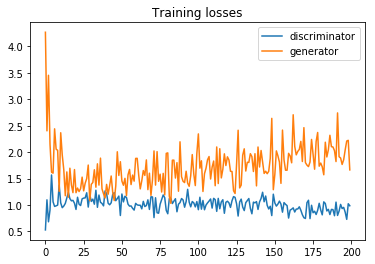

In [14]:
fig, ax = plt.subplots()

losses = np.array(losses)
plt.plot(losses.T[0], label='discriminator')
plt.plot(losses.T[1], label='generator')
plt.titlee('Training losses')
plt.legend()

## Muestras del Generador Durante el Entrenamiento

Veamos la evolución de las imágenes creadas por el generador mientras se entrenaba.

In [15]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img.reshape((28, 28)), cmap='gray')
        
    return fig, axes

In [16]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Veamos algunos ejemplos del último _epoch_.

(<matplotlib.figure.Figure at 0x7fb1b2799160>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1b23691d0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7fb1a631e860>]], dtype=object))

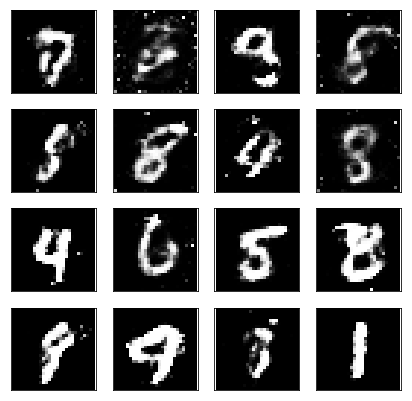

In [17]:
view_samples(-1, samples)

Ahora veamos imágenes generadas cada 10 _epochs_.

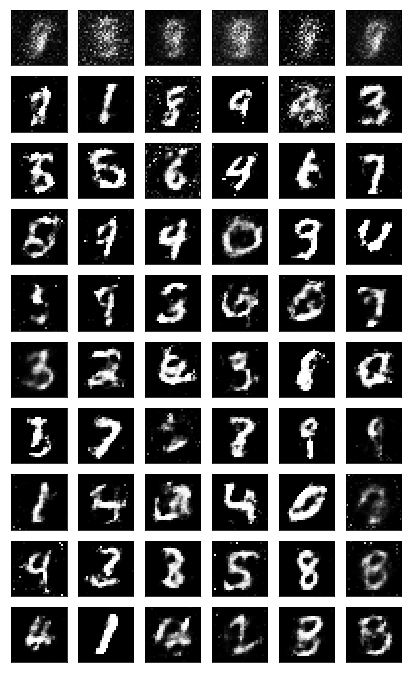

In [18]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7, 12), nrows=rows, ncols=cols, sharey=True, sharex=True)

for sample, ax_row in zip(samples[::int(len(samples) / rows)], axes):
    for img, ax in zip(sample[::int(len(sample) / cols)], ax_row):
        ax.imshow(img.reshape((28, 28)), cmap='gray')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Generando Imágenes Nuevas

Confeccionemos nuevas imágenes usando el generador que guardamos previamente.

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


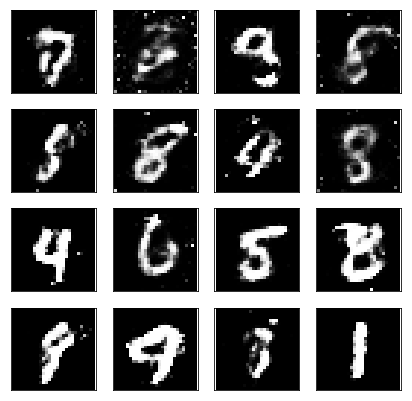

In [19]:
saver = tf.train.Saver(var_list=generator_variables)
with tf.Session() as s:
    saver.restore(s, tf.train.latest_checkpoint('checkpoints'))
    generated_sample = np.random.uniform(-1, 1, size=(16, GENERATED_INPUT_SIZE))
    generates_samples = s.run(generator(generated_input, REAL_INPUT_SIZE, number_of_units=GENERATOR_HIDDEN_SIZE, reuse=True, alpha=ALPHA),
                              feed_dict={generated_input: generated_sample})
    
    view_samples(0, [generated_samples])
    